In [1]:
using DelaunayTriangulation, CairoMakie;
using SparseArrays, LinearAlgebra;

In [2]:
const triangle_edge_length = 2.;
const max_area = 1e-3;
const min_angle = 31.5;
points = [
    (0., 0.),
    (triangle_edge_length, 0.),
    (0., triangle_edge_length),
    (0., 0.)
];
boundary_nodes, points = convert_boundary_points_to_indices(points);
triangle = triangulate(points; boundary_nodes);
refine!(triangle; max_area=max_area, min_angle=min_angle);

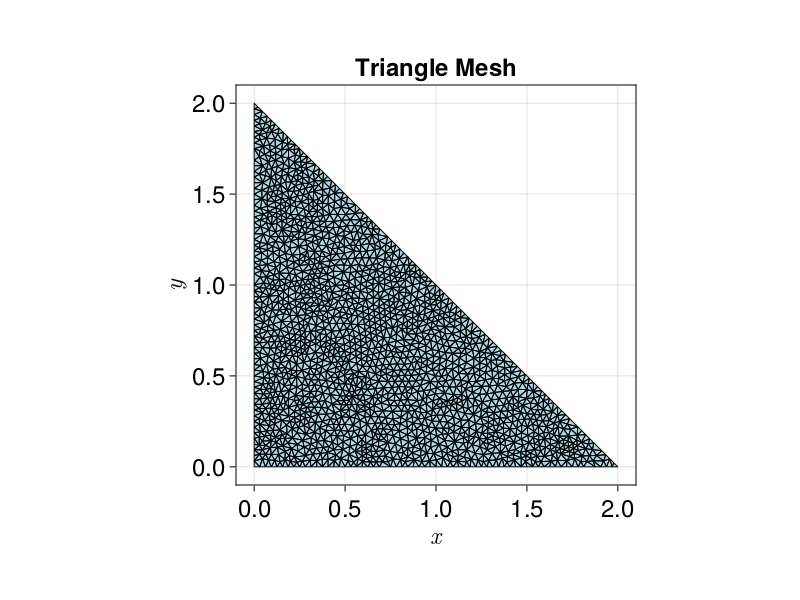

In [3]:
figure = Figure(fontsize=24)
axes = Axis(figure[1, 1], title="Triangle Mesh", titlealign=:center, width=400, height=400, xlabel=L"$x$", ylabel=L"$y$")
triplot!(axes, triangle, triangle_color=:lightblue)
save("../images/triangle_mesh.pdf", figure)
save("../images/triangle_mesh.png", figure)
figure

In [4]:
function generateStiffnessMatrix(triangle::Triangulation)
    n_nodes = length(triangle.points);
    stiffness_matrix = spzeros(n_nodes, n_nodes);
    for triangle_element in each_triangle(triangle)
        id1, id2, id3 = triangle_element;
        x1, y1 = triangle.points[id1];
        x2, y2 = triangle.points[id2];
        x3, y3 = triangle.points[id3];
        double_area = det(
            [1 x1 y1;
            1 x2 y2;
            1 x3 y3]
        );
        k11 = (x2 - x3)^2 + (y2 - y3)^2;
        k12 = (x1 - x3) * (-x2 + x3) + (y1 - y3) * (-y2 + y3);
        k13 = (x1 - x2) * (x2 - x3) + (y1 - y2) * (y2 - y3);
        k22 = (x1 - x3)^2 + (y1 - y3)^2;
        k23 = (x1 - x2) * (-x1 + x3) + (y1 - y2) * (-y1 + y3);
        k33 = (x1 - x2)^2 + (y1 - y2)^2;
        # first row
        stiffness_matrix[id1, id1] += k11 / double_area / 2;
        stiffness_matrix[id1, id2] += k12 / double_area / 2;
        stiffness_matrix[id1, id3] += k13 / double_area / 2;
        # second row
        stiffness_matrix[id2, id1] += k12 / double_area / 2;
        stiffness_matrix[id2, id2] += k22 / double_area / 2;
        stiffness_matrix[id2, id3] += k23 / double_area / 2;
        # third row
        stiffness_matrix[id3, id1] += k13 / double_area / 2;
        stiffness_matrix[id3, id2] += k23 / double_area / 2;
        stiffness_matrix[id3, id3] += k33 / double_area / 2;
    end
    return stiffness_matrix;
end

generateStiffnessMatrix (generic function with 1 method)

In [5]:
stiffness_matrix = generateStiffnessMatrix(triangle);
stiffness_matrix

1760×1760 SparseMatrixCSC{Float64, Int64} with 11896 stored entries:
⠑⢄⠀⠘⡀⢀⠠⠔⢵⣖⡔⠚⢭⣵⣬⡁⣌⣓⡷⡆⠲⠺⡹⢗⣷⣢⢮⣖⢲⣾⡃⢷⣷⡓⢿⣽⡾⣾⡆⣤
⣀⠀⠑⢄⠁⠀⠀⠃⠑⠘⡐⠲⢜⣀⣐⡉⡈⢉⢟⡆⠠⣶⢯⣇⡘⠾⢻⠶⣚⡹⠟⠿⡹⡛⢫⣳⣿⢾⣿⢷
⠀⢈⠁⠀⢑⢔⡈⡈⠰⠠⠅⠐⡲⠶⡮⠄⢠⣤⡻⣃⣀⡀⣖⣳⣪⣐⣇⣒⣞⠺⣏⡠⣙⣙⣺⢘⣕⡟⣛⣒
⢀⠆⠤⠀⡂⠨⠿⢇⢲⣀⣀⠈⢯⠄⢀⣀⣠⠤⡷⡵⠿⢛⠂⠗⣺⡺⢿⣿⢰⡟⡛⢼⣟⣬⢒⡟⢾⡺⣯⠙
⢱⢷⣑⠀⠐⡂⠘⢲⢱⣶⡅⠉⢘⠀⠀⠀⠀⢄⡅⠁⠀⢚⡏⢛⢨⠅⠁⣶⢰⡮⠃⢑⣙⠖⣿⢿⢲⠓⠲⠖
⣰⠉⢰⡈⢁⠁⡀⠘⡅⠉⢱⣶⡜⠀⠀⠂⠐⠁⡢⡂⠐⣒⣴⠒⠘⢗⠒⣬⢞⢳⣃⣲⠿⣆⢲⡍⢶⣵⣾⣽
⢇⣷⠒⢱⢸⡎⠋⠗⠒⠐⠒⠉⠻⣦⡤⠀⡀⢠⠌⠃⠃⢂⠀⣼⡘⠈⠙⠉⠾⠺⠝⠛⠁⠘⠫⡹⠞⠅⠑⠇
⠆⠻⡔⠸⠊⠏⠀⢰⠀⠀⠠⠀⠀⠋⢻⣶⣺⠬⡯⠄⠀⠈⡬⠎⢤⢀⡄⠀⠶⢳⠅⠮⢄⡖⣬⣸⡷⣡⣔⣂
⢦⢹⡆⢈⠀⣶⠀⡞⠀⢄⠔⠀⠀⣈⡚⡞⢻⣶⣇⠀⠀⠀⠐⢁⣷⠌⠞⡰⢲⢠⡆⢡⣚⠆⢔⡄⣓⠁⠄⠛
⠹⠯⠻⠵⠿⢪⢝⡯⠅⠉⠨⠪⠦⠁⠋⠏⠉⠙⠱⣦⣬⢁⠭⣆⡈⣼⠷⣕⢚⣹⡗⣅⡉⣻⣽⣏⣹⣤⢏⢍
⣸⡂⢠⣦⠀⠸⣿⢃⣠⢀⢰⢠⠩⢀⡀⠀⠀⠀⠆⢛⢻⣶⡁⣚⢫⢻⠲⢛⠸⣒⡨⠻⡫⠋⢗⣊⠚⠩⠲⣒
⢷⢎⠯⢷⢼⣹⢬⠄⣯⢉⢰⠛⣀⣤⡢⠏⠔⢀⠣⢧⣡⢨⡿⣯⡎⣋⢎⣅⡩⣅⣊⡞⡙⣄⡑⢿⡖⠾⢣⠘
⠹⣻⣲⡌⢊⢺⣺⡺⠆⠖⢶⢄⡒⠈⠀⢓⡙⠟⣂⣬⣯⣒⡮⢩⡻⣮⢄⢸⠀⠂⣈⢕⡓⡕⣺⣚⢷⠝⣸⢌
⢪⢷⢻⡖⢩⢹⣿⣷⢡⣤⡘⣤⡗⠀⠀⠉⢚⡡⢝⢧⣼⢂⠎⢵⣀⣑⢿⣷⡋⣢⠂⡐⡆⡉⢶⠦⢬⣀⡭⡇
⣸⣶⣞⡸⣺⡙⣴⠶⡰⡶⢾⣑⣺⡃⢼⣃⠘⣒⣞⣰⢲⢢⠇⢮⠠⠀⠫⣨⣛⣼⠅⠷⠖⠖⡃⡴⢸⡪⢿⡔
⢭⣌⣿⡅⠋⡹⣛⣌⢍⢀⢩⣸⣷⠁⡡⡅⠌⣉⠝⢭⣦⡊⣪⠼⢆⢜⢈⠠⢥⡅⡿⢏⣏⠘⡖⡉⢀⣤⣹⣤
⢽⠻⣷⠪⣗⢸⡛⣽⢳⠜⠻⢧⣁⠀⢠⠵⠺⠜⣧⣨⡯⠊⠓⢬⢝⠬⡌⠩⢸⠅⣋⠙⢿⣷⡋⠸⡪⠺⣶⢒
⣟⣷⢯⣲⣚⢚⣼⠴⣿⣟⡜⠶⣏⡢⣂⣻⠐⠵⡷⢿⡹⢱⣵⣌⣺⢺⠸⡗⢉⡬⡜⠩⣋⡈⠱⣦⣃⣻⣿⣟
⣺⣯⣻⣟⣵⠽⣺⡳⢼⠒⢜⣷⠞⠅⠝⣫⠝⠘⠓⣾⡞⡀⣸⡍⣝⠗⠂⢳⡲⡲⠀⣴⣪⡊⣭⣸⢿⣷⡏⣯
⠈⣭⢿⣟⢻⢸⣏⠛⢸⠆⣞⣿⠵⠄⠰⢹⣤⠁⡏⢕⢸⢢⣉⠒⡒⢞⠧⠯⢛⠷⠓⣾⢸⢛⣿⢿⡯⣭⠵⣧

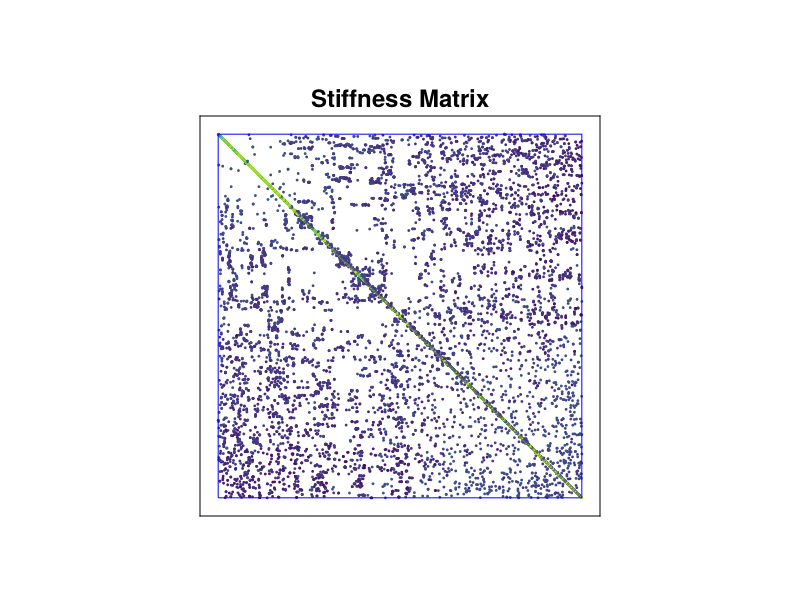

In [6]:
figure = Figure(fontsize=24)
axes = Axis(figure[1, 1], title="Stiffness Matrix", titlealign=:center, width=400, height=400)
spy!(axes, rotr90(stiffness_matrix), markersize=4, marker=:circle, framecolor=:blue)
hidedecorations!(axes)
save("../images/stiffness_matrix.pdf", figure)
save("../images/stiffness_matrix.png", figure)
figure

In [7]:
function isLeftBoundaryNode(x, y)
    return x == 0.
end

function generateSourceVector(triangle::Triangulation, neumann_boundary_value::Float64)
    n_nodes = length(triangle.points);
    source_vector = zeros(n_nodes);
    for triangle_element in each_triangle(triangle)
        boundary_nodes = [];
        id1, id2, id3 = triangle_element;
        x1, y1 = triangle.points[id1];
        x2, y2 = triangle.points[id2];
        x3, y3 = triangle.points[id3];
        node_dict = Dict(id1 => (x1, y1), id2 => (x2, y2), id3 => (x3, y3));
        for (id, (x, y)) in node_dict
            if isLeftBoundaryNode(x, y)
                push!(boundary_nodes, id);
            end
        end
        if length(boundary_nodes) == 2
            n1_id, n2_id = boundary_nodes;
            n1_x, n1_y = node_dict[n1_id];
            n2_x, n2_y = node_dict[n2_id];
            edge_length = sqrt((n1_x - n2_x)^2 + (n1_y - n2_y)^2);
            source_vector[n1_id] += neumann_boundary_value * edge_length / 2;
            source_vector[n2_id] += neumann_boundary_value * edge_length / 2;
        else
            continue;
        end
    end
    return source_vector;
end

generateSourceVector (generic function with 1 method)

In [8]:
source_vector = generateSourceVector(triangle, 1.);

In [9]:
function solve(
    stiffness_matrix::SparseMatrixCSC, 
    source_vector::Vector, 
    known_nodes_ids::Vector,
    known_nodes_values::Vector
)::Vector
    @assert length(known_nodes_ids) == length(known_nodes_values);
    n_nodes = length(source_vector);
    solution_vector = zeros(n_nodes);
    solution_vector[known_nodes_ids] .= known_nodes_values;
    unknown_nodes_ids = setdiff(1:n_nodes, known_nodes_ids);
    part_stiffness_matrix = stiffness_matrix[unknown_nodes_ids, unknown_nodes_ids];
    part_source_vector = (source_vector .- stiffness_matrix * solution_vector)[unknown_nodes_ids];
    solution_vector[unknown_nodes_ids] .= part_stiffness_matrix \ part_source_vector;
    return solution_vector;
end

solve (generic function with 1 method)

In [10]:
function isBottomBoundaryNode(x, y)
    return y == 0.;
end

known_nodes_ids = [];
known_nodes_values = [];
for (id, (x, y)) in enumerate(triangle.points)
    if isBottomBoundaryNode(x, y)
        push!(known_nodes_ids, id);
        push!(known_nodes_values, 0.);
    else
        continue;
    end
end
[known_nodes_ids, known_nodes_values]

2-element Vector{Vector{Any}}:
 [1, 2, 6, 9, 13, 18, 38, 61, 66, 74  …  1425, 1436, 1442, 1446, 1448, 1534, 1579, 1580, 1680, 1743]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [11]:
solution_vector = solve(stiffness_matrix, source_vector, known_nodes_ids, known_nodes_values);

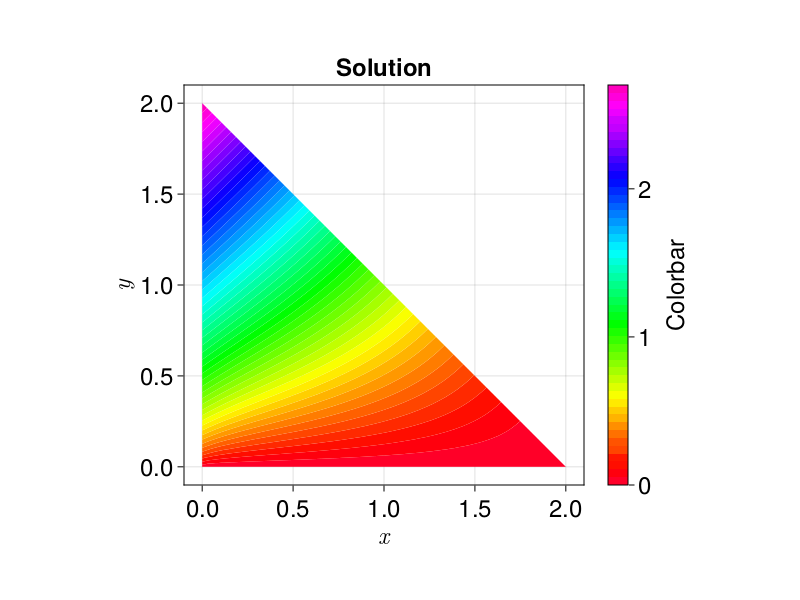

In [12]:
figure = Figure(fontsize=24)
axes = Axis(figure[1, 1], title="Solution", titlealign=:center, width=400, height=400, xlabel=L"$x$", ylabel=L"$y$")
tr = tricontourf!(axes, triangle, levels=51, solution_vector, colormap=:gist_rainbow)
Colorbar(figure[1, 2], tr, label="Colorbar", labelpadding=10, width=20, height=400)
save("../images/solution.pdf", figure)
save("../images/solution.png", figure)
figure